# Etapa 1: Análise e Limpeza dos Dados

In [1]:
!pip install openpyxl


[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Bibliotecas
import pandas as pd
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import seaborn as sns

# Dicionário de Dados - Online Retail

| Nome da Coluna    | Descrição                                                                 |
|-------------------|---------------------------------------------------------------------------|
| NumeroFatura      | Número da fatura que identifica a transação.                              |
| CodigoProduto     | Código do produto que foi vendido.                                        |
| Descricao         | Descrição do produto vendido.                                             |
| Quantidade        | Quantidade de produtos vendidos na transação.                             |
| DataFatura        | Data e hora em que a fatura foi gerada.                                   |
| PrecoUnitario     | Preço unitário do produto vendido.                                        |
| IDCliente         | Identificação única do cliente que realizou a compra.                     |
| Pais              | País onde o cliente está localizado.                                      |


In [3]:
#Abrindo arquivo excel e transformando em DataFrame
file_path = "online_retail.xlsx"
df = pd.read_excel(file_path)


# Renomeando as colunas para o português

In [4]:
# Renomear as colunas para o português
df.rename(columns={
    'InvoiceNo': 'NumeroFatura',
    'StockCode': 'CodigoProduto',
    'Description': 'Descricao',
    'Quantity': 'Quantidade',
    'InvoiceDate': 'DataFatura',
    'UnitPrice': 'PrecoUnitario',
    'CustomerID': 'IDCliente',
    'Country': 'Pais'
}, inplace=True)

In [5]:
# Compreendendo as colunas
df.columns

Index(['NumeroFatura', 'CodigoProduto', 'Descricao', 'Quantidade',
       'DataFatura', 'PrecoUnitario', 'IDCliente', 'Pais'],
      dtype='object')

In [6]:
df.head()

,NumeroFatura,CodigoProduto,Descricao,Quantidade,DataFatura,PrecoUnitario,IDCliente,Pais
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [7]:
df.tail()

,NumeroFatura,CodigoProduto,Descricao,Quantidade,DataFatura,PrecoUnitario,IDCliente,Pais
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [8]:
# Estrutura do DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   NumeroFatura   541909 non-null  object        
 1   CodigoProduto  541909 non-null  object        
 2   Descricao      540455 non-null  object        
 3   Quantidade     541909 non-null  int64         
 4   DataFatura     541909 non-null  datetime64[ns]
 5   PrecoUnitario  541909 non-null  float64       
 6   IDCliente      406829 non-null  float64       
 7   Pais           541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


Podemos observar que as colunas "Descricao" e "IDCliente" possuem valores ausentes. Como estes dados são essenciais para as análises posteriores, imputar dados como moda, mediana ou média poderia distorcer as análises posteriores, manter esses dados, pode induzir a tomadas de decisão igualmente incorretas.

Como o nosso conjunto de dados é bastante robusto, a estratégia adotada será excluir os valores ausentes, desta forma, esperamos obter maior precisão em nossas análises.

In [9]:
# Excluindo valores ausentes
df.dropna(inplace=True)

In [10]:
#Verificando se ainda existem valores ausentes
df.isnull().sum()

NumeroFatura     0
CodigoProduto    0
Descricao        0
Quantidade       0
DataFatura       0
PrecoUnitario    0
IDCliente        0
Pais             0
dtype: int64

In [11]:
# Verificando valores duplicados
df.duplicated().sum()

5225

Conforme observamos acima, possuímos 5225 valores duplicados. Encontramos mais um problema que pode distorcer nas análises posteriores. Assim, optamos por também excluir estas linhas conforme a codificação abaixo:

In [12]:
#Excluindo as linhas duplicadas
df.drop_duplicates(inplace=True)

In [13]:
# Conferindo novamente o DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype         
---  ------         --------------   -----         
 0   NumeroFatura   401604 non-null  object        
 1   CodigoProduto  401604 non-null  object        
 2   Descricao      401604 non-null  object        
 3   Quantidade     401604 non-null  int64         
 4   DataFatura     401604 non-null  datetime64[ns]
 5   PrecoUnitario  401604 non-null  float64       
 6   IDCliente      401604 non-null  float64       
 7   Pais           401604 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 27.6+ MB


In [14]:
# Verificar CodigoProduos unicos e quantos são  
df['CodigoProduto'].nunique()

3684

In [15]:
# Verificar Descricao unicas e quantos são
df['Descricao'].nunique()

3896


Dada a grande quantidade de produtos, é essencial simplificar as análises subsequentes. Para isso, faremos uma limpeza na coluna 'Descrição' para remover caracteres especiais e normalizar o texto. Em seguida, utilizaremos a técnica TF-IDF (Term Frequency-Inverse Document Frequency) para transformar as descrições dos produtos em vetores numéricos. Com esses vetores, aplicaremos um algoritmo de clusterização para criar uma nova coluna de categorias. Essa nova coluna permitirá visualizações mais claras, distinção eficaz dos produtos e facilitará a geração de insights acionáveis de maneira mais abrangente

In [16]:
# Função para limpar as descrições
def limpar_descricao(descricao):
    descricao = descricao.lower()  # Converter para minúsculas
    descricao = re.sub(r'[^a-z\s]', '', descricao)  # Remover caracteres especiais e números
    return descricao

# Aplicar a função de limpeza às descrições
df['DescricaoLimpa'] = df['Descricao'].apply(limpar_descricao)


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   NumeroFatura    401604 non-null  object        
 1   CodigoProduto   401604 non-null  object        
 2   Descricao       401604 non-null  object        
 3   Quantidade      401604 non-null  int64         
 4   DataFatura      401604 non-null  datetime64[ns]
 5   PrecoUnitario   401604 non-null  float64       
 6   IDCliente       401604 non-null  float64       
 7   Pais            401604 non-null  object        
 8   DescricaoLimpa  401604 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(5)
memory usage: 30.6+ MB


# Vetorização usando TF-IDF

In [18]:
# Tokenizar e vetorizar as descrições
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(df['DescricaoLimpa'])


Definindo o número ideial de clusters sendo a variável X equivalente à DescricaoLimpa

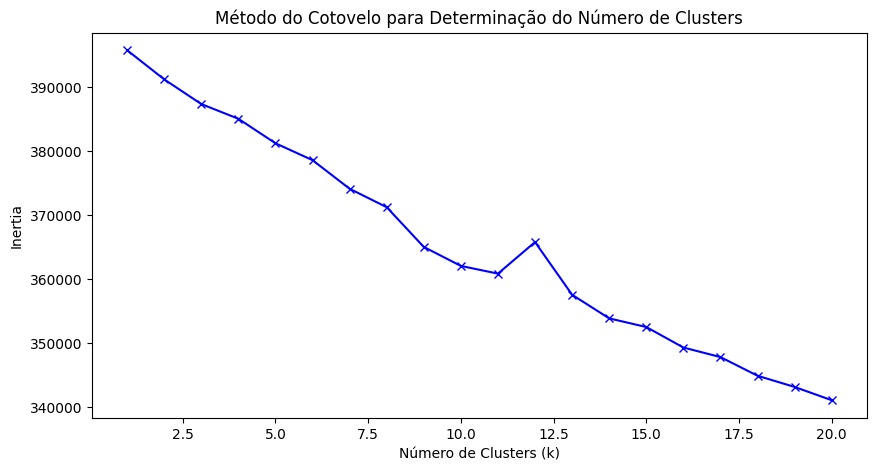

In [19]:
# Definir o intervalo de possíveis valores de clusters
k_values = range(1, 21)
inertia_values = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia_values.append(kmeans.inertia_)

# Plotar o gráfico do método do cotovelo
plt.figure(figsize=(10, 5))
plt.plot(k_values, inertia_values, 'bx-')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inertia')
plt.title('Método do Cotovelo para Determinação do Número de Clusters')
plt.show()

In [20]:
# Definir o número de clusters baseado no método do cotovelo
num_clusters = 8

# Aplicar K-means com o número de clusters selecionado
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(X)

In [21]:
# Agrupar por categoria e contar o número de produtos em cada cluster
produtos_por_categoria = df.groupby('Cluster').size()
print(produtos_por_categoria)

# Mostrar alguns produtos de cada cluster
for cluster_num in range(num_clusters):
    print(f"Cluster {cluster_num}:")
    produtos_no_cluster = df[df['Cluster'] == cluster_num][['CodigoProduto', 'Descricao']].head(10)
    print(produtos_no_cluster)
    print("\n")

Cluster
0     39932
1    237441
2     11274
3     17120
4     22834
5     23406
6     32149
7     17448
dtype: int64
Cluster 0:
    CodigoProduto                          Descricao
5           22752       SET 7 BABUSHKA NESTING BOXES
21          22960           JAM MAKING SET WITH JARS
40          22900    SET 2 TEA TOWELS I LOVE LONDON 
46          22086    PAPER CHAIN KIT 50'S CHRISTMAS 
63          22752       SET 7 BABUSHKA NESTING BOXES
80          22752       SET 7 BABUSHKA NESTING BOXES
91         84997C  BLUE 3 PIECE POLKADOT CUTLERY SET
92          21094      SET/6 RED SPOTTY PAPER PLATES
100        84519A    TOMATO CHARLIE+LOLA COASTER SET
105         22961             JAM MAKING SET PRINTED


Cluster 1:
   CodigoProduto                            Descricao
2         84406B       CREAM CUPID HEARTS COAT HANGER
3         84029G  KNITTED UNION FLAG HOT WATER BOTTLE
7          22633               HAND WARMER UNION JACK
8          22632            HAND WARMER RED POLKA DOT
9     

Análise dos Produtos em Cada Cluster

In [22]:
from collections import Counter
import re

def palavras_mais_comuns(descricoes, top_n=20):
    todas_palavras = ' '.join(descricoes).lower()
    todas_palavras = re.findall(r'\b\w+\b', todas_palavras)  # Pegar apenas palavras
    contador_palavras = Counter(todas_palavras)
    return contador_palavras.most_common(top_n)

# Analisar produtos em cada cluster para identificar padrões
palavras_clusters = {}
for cluster_num in range(num_clusters):
    print(f"Cluster {cluster_num}:")
    produtos_no_cluster = df[df['Cluster'] == cluster_num]['DescricaoLimpa']
    palavras_comuns = palavras_mais_comuns(produtos_no_cluster, top_n=20)
    palavras_clusters[cluster_num] = palavras_comuns
    print(f"Palavras mais comuns no Cluster {cluster_num}: {palavras_comuns}\n")


Cluster 0:
Palavras mais comuns no Cluster 0: [('set', 38044), ('of', 16984), ('paper', 5561), ('retrospot', 3394), ('tins', 2812), ('tea', 2624), ('pantry', 2592), ('wooden', 2562), ('baking', 2325), ('kit', 2152), ('jam', 2071), ('design', 2044), ('chain', 2001), ('heart', 1956), ('making', 1849), ('cookie', 1773), ('cutters', 1674), ('party', 1653), ('candles', 1632), ('piece', 1631)]

Cluster 1:
Palavras mais comuns no Cluster 1: [('bag', 22186), ('design', 16691), ('pink', 14928), ('metal', 14262), ('box', 14117), ('sign', 12682), ('blue', 11842), ('lunch', 11162), ('christmas', 9544), ('jumbo', 8660), ('card', 7866), ('polkadot', 7359), ('home', 7209), ('bottle', 7000), ('of', 6844), ('hot', 6403), ('and', 6216), ('regency', 6208), ('feltcraft', 6084), ('water', 6031)]

Cluster 2:
Palavras mais comuns no Cluster 2: [('tin', 7521), ('woodland', 4353), ('in', 3569), ('plasters', 3141), ('vintage', 2149), ('bag', 1985), ('round', 1188), ('biscuit', 1125), ('animals', 1106), ('lunch'

In [23]:
df.columns

Index(['NumeroFatura', 'CodigoProduto', 'Descricao', 'Quantidade',
       'DataFatura', 'PrecoUnitario', 'IDCliente', 'Pais', 'DescricaoLimpa',
       'Cluster'],
      dtype='object')

Agora, com base nas palvaras mais comuns em cada cluster, podemos agrupá-las em uma categoria específica. Além disso, renomearemos a coluna cluster para Categoria 

In [24]:
nomes_clusters = {
    0: 'Conjuntos e Kits para Cozinha e Confeitaria',
    1: 'Bolsas, Decoração e Presentes',
    2: 'Latas, Vintage e Brinquedos',
    3: 'Decoração de Interiores e Móveis',
    4: 'Vintage, Natal e Decoração',
    5: 'Sacolas, Lanches e Utilidades Retrospot',
    6: 'Decoração e Iluminação',
    7: 'Acessórios para Bolos, Festas e Decoração',
}

# Atribuir os nomes aos clusters no DataFrame
df['Categoria'] = df['Cluster'].map(nomes_clusters)

# Remover a coluna 'Cluster'
df = df.drop(columns=['Cluster'])

# Contar a quantidade de dados em cada cluster
produtos_por_categoria = df.groupby('Categoria').size()
print(produtos_por_categoria)

Categoria
Acessórios para Bolos, Festas e Decoração       17448
Bolsas, Decoração e Presentes                  237441
Conjuntos e Kits para Cozinha e Confeitaria     39932
Decoração de Interiores e Móveis                17120
Decoração e Iluminação                          32149
Latas, Vintage e Brinquedos                     11274
Sacolas, Lanches e Utilidades Retrospot         23406
Vintage, Natal e Decoração                      22834
dtype: int64


Com base nas categorias acima, identificamos que Bolsas, Decoração e Presentes são os produtos mais representativos em nossa base de dados.

In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401604 entries, 0 to 541908
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   NumeroFatura    401604 non-null  object        
 1   CodigoProduto   401604 non-null  object        
 2   Descricao       401604 non-null  object        
 3   Quantidade      401604 non-null  int64         
 4   DataFatura      401604 non-null  datetime64[ns]
 5   PrecoUnitario   401604 non-null  float64       
 6   IDCliente       401604 non-null  float64       
 7   Pais            401604 non-null  object        
 8   DescricaoLimpa  401604 non-null  object        
 9   Categoria       401604 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 33.7+ MB


A Partir do código acima, observamos que após a criação da coluna Categoria (utilizando TF-IDF e KNN), agora possuímos 8 grupos de produtos definidos conforme as características mais comuns entre si.

Agora, visualizaremos estatísticas básicas, nosso objetivo será detectar outras anomalias em nossos dados númericos.

In [26]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantidade,401604.0,12.183273,-80995.0,2.0,5.0,12.0,80995.0,250.283037
DataFatura,401604,2011-07-10 12:08:23.848567552,2010-12-01 08:26:00,2011-04-06 15:02:00,2011-07-29 15:40:00,2011-10-20 11:58:30,2011-12-09 12:50:00,NaN
PrecoUnitario,401604.0,3.474064,0.0,1.25,1.95,3.75,38970.0,69.764035
IDCliente,401604.0,15281.160818,12346.0,13939.0,15145.0,16784.0,18287.0,1714.006089


Podemos observar algumas inconscistências que devem ser mais investigadas a fundo. Abaixo, trataremos cada um dos problemas encontrados:

1. Preço Unitário (PrecoUnitario):
min = 0.0: Ter um preço unitário igual a zero pode indicar um erro na coleta de dados. É improvável que um produto seja vendido por zero.

In [27]:
df_zero_preco = df[df['PrecoUnitario'] == 0]
produtos_por_categoria = df_zero_preco.groupby('Categoria').size()
print(produtos_por_categoria)

Categoria
Acessórios para Bolos, Festas e Decoração       2
Bolsas, Decoração e Presentes                  19
Conjuntos e Kits para Cozinha e Confeitaria     8
Decoração de Interiores e Móveis                1
Decoração e Iluminação                          3
Latas, Vintage e Brinquedos                     4
Sacolas, Lanches e Utilidades Retrospot         2
Vintage, Natal e Decoração                      1
dtype: int64


Com base nos resultados acima, observamos que a quantidade de produtos com valor 0 não é substancial. Estes dados podem ser 'cortesia', porém, isso parece improvável sendo mais provável erros de digitação. Assim, nossa abordagem será excluir estes valores já que não colaboram com nossas análises.

In [28]:
# Excluindo linhas com PrecoUnitario igual a zero
df = df[df['PrecoUnitario'] != 0]

Nosso segundo problema foi encontrado em DataFatura com valores NaN. Agora investigaremos esta questão:

In [29]:
# Verificando valores NaN na coluna 'DataFatura'
datas_faltantes = df['DataFatura'].isna().sum()
print(f"Número de linhas com data faltante: {datas_faltantes}")

Número de linhas com data faltante: 0


Observamos que não possuímos valores NaN em DataFatura, isso é resultado pela forma com que o Describe() lida com tipo de dados Datetime, portanto, não temos nenhum problema aqui.

In [30]:

faturas_faltantes = df['NumeroFatura'].isna().sum()
print(f"Número de linhas com fatura faltante: {faturas_faltantes}")

Número de linhas com fatura faltante: 0


In [31]:
# Contando linhas com Quantidade negativa
quantidade_negativa = df[df['Quantidade'] < 0].shape[0]
print(f"Número de linhas com quantidade negativa: {quantidade_negativa}")


Número de linhas com quantidade negativa: 8872


Observamos uma quantidade substancial de valores negativos na coluna Quantidade. Inicialmente, esses valores poderiam indicar erros de digitação. No entanto, conforme os requisitos do cliente, é necessário apresentar as devoluções. Portanto, é mais provável que esses valores negativos representem devoluções de produtos. Para atender a essa necessidade, criaremos duas novas colunas: Venda, para indicar as transações efetivadas, e Devolucao, para indicar as transações que são devoluções. 

In [32]:
# Adicionar uma coluna para indicar se a transação é uma devolução
df['Devolucao'] = df['Quantidade'].apply(lambda x: True if x < 0 else False)

# Adicionar uma coluna para indicar se a transação é uma venda (oposto da coluna Devolucao)
df['Venda'] = df['Devolucao'].apply(lambda x: not x)

# Mostrar algumas linhas do DataFrame para verificar as novas colunas
print("Primeiras linhas do DataFrame após adicionar as colunas Devolucao e Venda:")
print(df.head())

Primeiras linhas do DataFrame após adicionar as colunas Devolucao e Venda:
  NumeroFatura CodigoProduto                            Descricao  Quantidade   
0       536365        85123A   WHITE HANGING HEART T-LIGHT HOLDER           6  \
1       536365         71053                  WHITE METAL LANTERN           6   
2       536365        84406B       CREAM CUPID HEARTS COAT HANGER           8   
3       536365        84029G  KNITTED UNION FLAG HOT WATER BOTTLE           6   
4       536365        84029E       RED WOOLLY HOTTIE WHITE HEART.           6   

           DataFatura  PrecoUnitario  IDCliente            Pais   
0 2010-12-01 08:26:00           2.55    17850.0  United Kingdom  \
1 2010-12-01 08:26:00           3.39    17850.0  United Kingdom   
2 2010-12-01 08:26:00           2.75    17850.0  United Kingdom   
3 2010-12-01 08:26:00           3.39    17850.0  United Kingdom   
4 2010-12-01 08:26:00           3.39    17850.0  United Kingdom   

                        DescricaoLi

In [33]:
# Contagem de transações que são devoluções
print("Contagem de transações que são devoluções:")
print(df['Devolucao'].value_counts())

Contagem de transações que são devoluções:
Devolucao
False    392692
True       8872
Name: count, dtype: int64


In [34]:
# Contagem de transações que são devoluções
print("Contagem de transações que são vendas:")
print(df['Venda'].value_counts())

Contagem de transações que são vendas:
Venda
True     392692
False      8872
Name: count, dtype: int64


Acima, observamos que possuímos 392692 vendas e 8872 devoluções.

In [35]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401564 entries, 0 to 541908
Data columns (total 12 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   NumeroFatura    401564 non-null  object        
 1   CodigoProduto   401564 non-null  object        
 2   Descricao       401564 non-null  object        
 3   Quantidade      401564 non-null  int64         
 4   DataFatura      401564 non-null  datetime64[ns]
 5   PrecoUnitario   401564 non-null  float64       
 6   IDCliente       401564 non-null  float64       
 7   Pais            401564 non-null  object        
 8   DescricaoLimpa  401564 non-null  object        
 9   Categoria       401564 non-null  object        
 10  Devolucao       401564 non-null  bool          
 11  Venda           401564 non-null  bool          
dtypes: bool(2), datetime64[ns](1), float64(2), int64(1), object(6)
memory usage: 34.5+ MB


In [36]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
Quantidade,401564.0,12.149911,-80995.0,2.0,5.0,12.0,80995.0,249.512649
DataFatura,401564,2011-07-10 12:06:07.514567936,2010-12-01 08:26:00,2011-04-06 15:02:00,2011-07-29 15:32:30,2011-10-20 11:58:00,2011-12-09 12:50:00,NaN
PrecoUnitario,401564.0,3.47441,0.001,1.25,1.95,3.75,38970.0,69.767501
IDCliente,401564.0,15281.266797,12346.0,13939.0,15145.0,16788.0,18287.0,1713.978947


Por fim, criaremos uma nova coluna com o valor total e também outra coluna para categorizar produtos com base em seus preços, sendo: Barato, Moderado e Caro

In [37]:
# Criar uma coluna que representa o valor total (Quantidade * PrecoUnitario)
df['ValorTotal'] = df['Quantidade'] * df['PrecoUnitario']

# Categorizar produtos com base no preço unitário
def categorize_price(price):
    if price < 5:
        return 'Barato'
    elif price < 20:
        return 'Moderado'
    else:
        return 'Caro'

df['CategoriaPreco'] = df['PrecoUnitario'].apply(categorize_price)

In [38]:
# Verificar a quantidade de valores em cada categoria
categoria_counts = df['CategoriaPreco'].value_counts()
print(categoria_counts)

CategoriaPreco
Barato      348645
Moderado     51560
Caro          1359
Name: count, dtype: int64


In [39]:
# Verificando o valor total dos produtos vendidos
valor_total = df['ValorTotal'].sum()
print(f'Valor Total: {valor_total}')

Valor Total: 8278519.4240000015


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 401564 entries, 0 to 541908
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype         
---  ------          --------------   -----         
 0   NumeroFatura    401564 non-null  object        
 1   CodigoProduto   401564 non-null  object        
 2   Descricao       401564 non-null  object        
 3   Quantidade      401564 non-null  int64         
 4   DataFatura      401564 non-null  datetime64[ns]
 5   PrecoUnitario   401564 non-null  float64       
 6   IDCliente       401564 non-null  float64       
 7   Pais            401564 non-null  object        
 8   DescricaoLimpa  401564 non-null  object        
 9   Categoria       401564 non-null  object        
 10  Devolucao       401564 non-null  bool          
 11  Venda           401564 non-null  bool          
 12  ValorTotal      401564 non-null  float64       
 13  CategoriaPreco  401564 non-null  object        
dtypes: bool(2), datetime64[ns](1), float64(3)

# Visualização dos dados

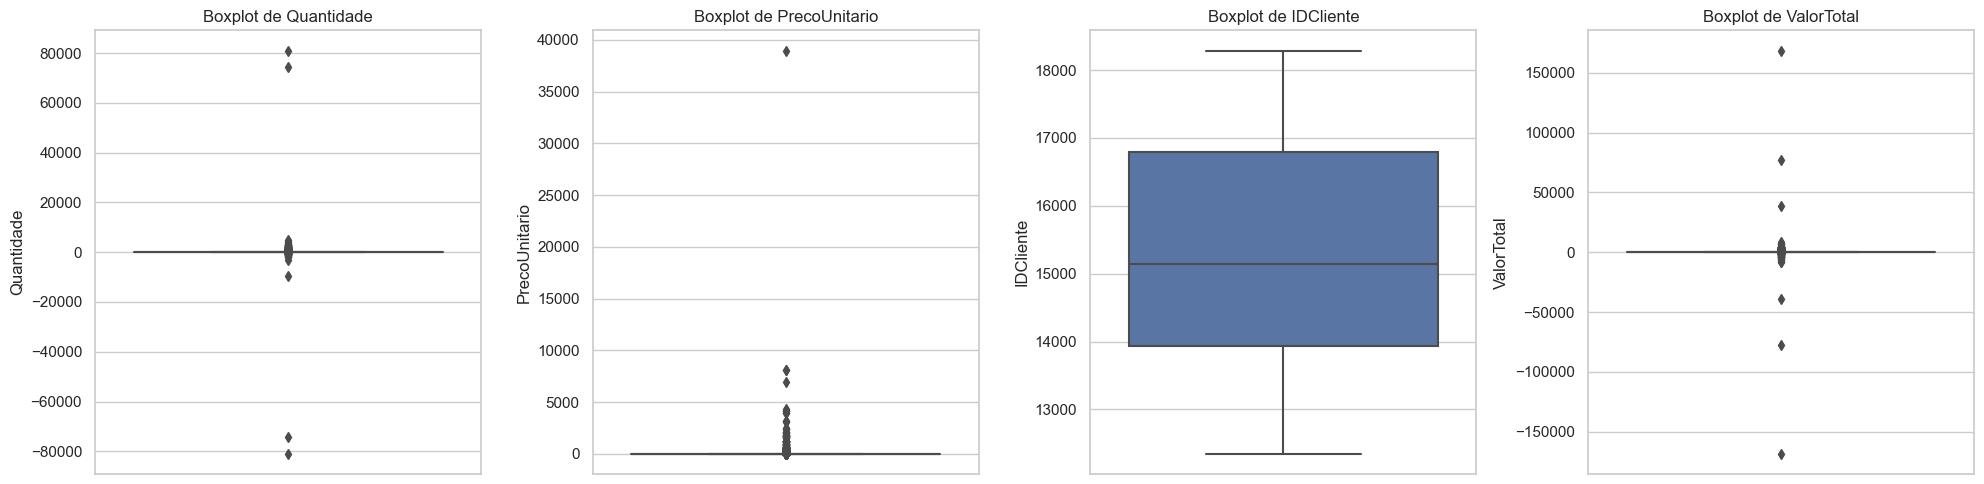

In [41]:
# Configurando o estilo dos plots
sns.set(style="whitegrid")

# Selecionando colunas numéricas
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Criando subplots dinamicamente com base no número de colunas
num_plots = len(numeric_columns)
fig, axes = plt.subplots(1, num_plots, figsize=(5 * num_plots, 5))

# Criando um boxplot para cada coluna numérica
for ax, col in zip(axes, numeric_columns):
    sns.boxplot(y=df[col], ax=ax)
    ax.set_title(f'Boxplot de {col}')

plt.tight_layout()
plt.show()


Com base nos boxplots acima, observamos a presença de outliers significativos nas colunas 'Quantidade' e 'PrecoUnitario'. Como a principio nosso objetivo é análise de dados (e não Machine Learning) e como clientes podem comprar muitos ou poucos produtos, nossa abordagem será mantê-los por concluirmos que este é o motivo mais provável.

# Conclusão Etapa 1

Observamos que iniciamos nosso conjunto de dados com 541909 registros e, finalmente após a limpeza, análise dos dados e a criação de 5 novas colunas ("Categoria", "ValorTotal", "CategoriaPreco", "Venda", "Devolucao"); reduzimos para 392692 registros. Agora, estamos prontos para exportar o DataFrame para um banco de dados SQL. 

Salvando em 3 DataFrames diferentes para posterior modelagem dos dados 

In [42]:
# Criar DataFrame para clientes e garantir que não há duplicatas
df_clientes = df[['IDCliente', 'Pais']].drop_duplicates(subset=['IDCliente'])

# Criar DataFrame para produtos e garantir que não há duplicatas
df_produtos = df[['CodigoProduto', 'Descricao', 'Categoria', 'PrecoUnitario', 'CategoriaPreco']].drop_duplicates(subset=['CodigoProduto'])

# Criar DataFrame para itens de fatura incluindo as novas colunas Venda e Devolucao
df_itens_fatura = df[['NumeroFatura', 'CodigoProduto', 'IDCliente', 'DataFatura', 'Quantidade', 'ValorTotal', 'Venda', 'Devolucao']]

# Salvando os DataFrames em arquivos CSV
df_clientes.to_csv('clientes.csv', index=False)
df_produtos.to_csv('produtos.csv', index=False)
df_itens_fatura.to_csv('itens_fatura.csv', index=False)

print("DataFrames salvos em arquivos CSV com sucesso!")

DataFrames salvos em arquivos CSV com sucesso!


In [43]:
pip install pandas sqlalchemy psycopg2-binary


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [44]:
import pandas as pd

# Carregar o arquivo CSV
df_itens_fatura = pd.read_csv('C:/temp/itens_fatura.csv')

# Encontrar duplicatas baseadas nas colunas 'NumeroFatura' e 'CodigoProduto'
duplicatas = df_itens_fatura[df_itens_fatura.duplicated(subset=['NumeroFatura', 'CodigoProduto'], keep=False)]

print(duplicatas)

Empty DataFrame
Columns: [NumeroFatura, CodigoProduto, IDCliente, DataFatura, Quantidade, ValorTotal, Venda, Devolucao]
Index: []


In [45]:
# Remover duplicatas mantendo apenas a primeira ocorrência
df_itens_fatura = df_itens_fatura.drop_duplicates(subset=['NumeroFatura', 'CodigoProduto'])

# Salvar o DataFrame limpo de volta para o CSV
df_itens_fatura.to_csv('C:/temp/itens_fatura.csv', index=False)
